# Assignment 2 - Pump it Up: Data Mining the water table
An attempt to predict which water pumps are going to continue working, which are going to need repairs and which are going to fail.
It is a multiclass classification problem to predict which water pumps will fall in either of the three groups. The data is available from Taarifa and Tanzanian Ministry of Water.

Link to Taarifa's website: http://taarifa.org

Link to Tanzanian Ministry of Water website: http://maji.go.tz

Link to data competition and data set: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/

### Username: DeodattaJ
### Score: 0.8172
### Rank: 397
### Link to leaderboard: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/leaderboard/

## Summary
1. Exploring train data from two files and test data from one file.
    1. The general approach is to explore each column at a time and make appropriate changes
    2. If a particular column has information connected with other columns, I treat all those columns together
2. The available train set has skewed distribution with respect to the three categories. I need to account for it when building a model.
3. Outliers are transformed by brining them within 99.9th percentile.
4. Categorical variables are transformed in different ways and the decision is made on case by case basis.
5. Some columns aren't directly useful in their form available. Some transformations are made to such columns to include that information and for such columns, a new column is created and the old ones are discarded.
6. When all transformations are done
    1. I have a data frame with all int/float/bool columns
    2. A correlation plot is then made to inspect if I have made the correct transformation
    3. The goal is to have a correlation plot with minimum correlations among columns so that I capture all information without repetitions
7. Once I have made the choice on columns, I then run differnt classifiers to get a benchmark of which perform better than others. Here is a list of classifiers I use here
    1. GaussianNB
    2. LogisticRegression
    3. KNeighborsClassifier
    4. GradientBoostingClassifier
    5. XGBClassifier
    6. RandomForestClassifier
8. Some algorithms perform better than others. For the current problem, RandomForestClassifier provides significantly better results than other classifiers. However, I also try to make a comparison with differnt classifiers by making some transformations to data to confirm that other classifiers are better or not with the transformations.
9. It turns out that the best suited algorithm here is the RandomForestClassifier.
    1. Now I decide to tune the algorithm parameters to check for optimal parameters.
    2. Since we are grouping the data into 3 final categories, initially I expected tree height of 8 - 10 to be good enough.
    3. Turns out eventually a tree height of 20 provides the best results. Checked within range 4 - 25.

## Importing the required packages
pandas & numpy for data frame operations
seaborn & matplotlib for plotting and charting data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

libraries for classifier algorithms. Mostly from sklearn and one from xgboost.

In [2]:
# Imports for different models for prediction
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.datasets as datasets
from sklearn import preprocessing

from xgboost import XGBClassifier

## Look at only important warnings & errors

In [3]:
# Set default warning display level
warnings.filterwarnings("ignore")

# Set charts to display automatically on executing the code line
# %matplotlib inline

pd.set_option('display.max_columns', None)

## Importing the data
We import the 3 data sets as 3 seprate data frames.
We create a new data frame which merges the train & test data set. This is important for all transformations we will be performing since the transformations must be same for both train and test data.

I prepare a separate list of columns which have been treated. Throughout the code I keep appending columns names to this list. Lastly, before running the models, I remove all the treated columns.

In [4]:
labels = pd.read_csv("Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv")
test = pd.read_csv("Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv")
train = pd.read_csv("Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv")

df = train.drop('id', axis = 1)
df = df.append(test)
drop_cols_list = pd.Series()

In [5]:
print(df.columns.unique())

Index(['amount_tsh', 'basin', 'construction_year', 'date_recorded',
       'district_code', 'extraction_type', 'extraction_type_class',
       'extraction_type_group', 'funder', 'gps_height', 'id', 'installer',
       'latitude', 'lga', 'longitude', 'management', 'management_group',
       'num_private', 'payment', 'payment_type', 'permit', 'population',
       'public_meeting', 'quality_group', 'quantity', 'quantity_group',
       'recorded_by', 'region', 'region_code', 'scheme_management',
       'scheme_name', 'source', 'source_class', 'source_type', 'subvillage',
       'ward', 'water_quality', 'waterpoint_type', 'waterpoint_type_group',
       'wpt_name'],
      dtype='object')


### Different columns provide information on different attributes
A guess on what information each column provides before I continue. There might be some columns which might be grouped under multiple categories but for now I assume that the following categories are good enought to prelinimary understanding.

##### Of location, geography and local administration
basin, district_code, gps_height, latitude, lga, longitude, region, region_code, ward, subvillage

##### Of technology
construction_year, extraction_type, extraction_type_class, extraction_type_group

##### Of quality
quality_group, quantity, quantity_group

##### Of water source
basin, source, source_class, source_type

##### Of operations
funder, installer, permit, management, management_group, scheme_management, scheme_name

##### Of water pump category
waterpoint_type, waterpoint_type_group, wpt_name

##### Others
id, num_private, recorded_by, 

The id column is important only for merging the train set with its labels. Here I am not dealing with the merge in df data frame so we drop it.

In [6]:
drop_cols_list = drop_cols_list.append( pd.Series(['id'] ))

The recorded_by column has only one value. This isn't useful in predictions.

There isn't much information available on the num_private column. This cannot be used for prediction as well.

I remove both columns.

In [7]:
drop_cols_list = drop_cols_list.append(pd.Series( ['recorded_by', 'num_private'] ))

___

___

___

A plot of all labelled values to se how many pump fall under which label.

#### From here onwards we take a look at each column one-by-one to understand the data and make appropriate changes for fixing outliers, imputing NAs and creating new features.

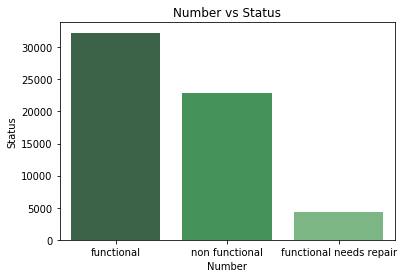

In [8]:
sns.countplot(x="status_group", data=labels, palette="Greens_d")
plt.title('Number vs Status')
plt.xlabel('Number')
plt.ylabel('Status')
plt.show()

___

___

___

### The amount_tsh column
The amount_tsh columns tells us about the total static head. This can be considered as the height to which the pump needs to push the water above the surface of water. This might be an important column as the load on the pump and the capacity of the pump can be effective in predicting failure rate. We do not have information on the capacity of the pump. Nonetheless, it is important to look at the values for TSH.

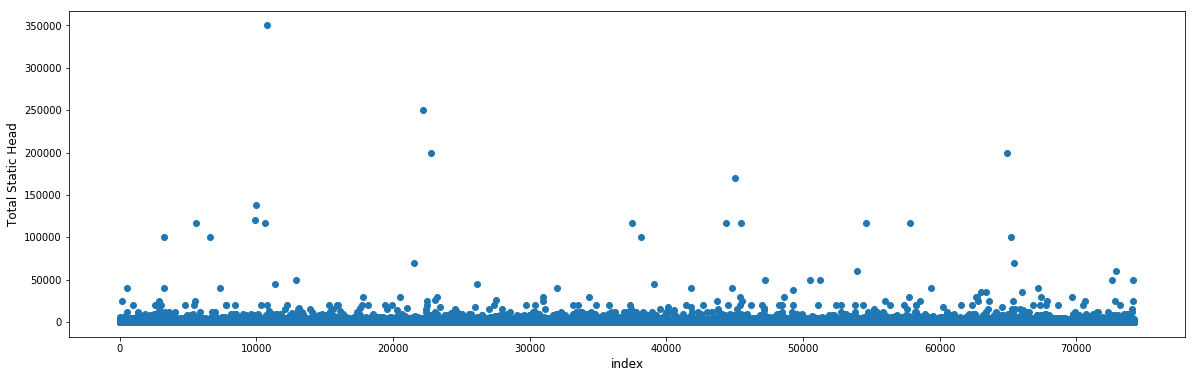

In [9]:
plt.figure(figsize=(20,6))
plt.scatter(range(df.shape[0]), df.amount_tsh.values)
plt.xlabel('index', fontsize=12)
plt.ylabel('Total Static Head', fontsize=12)
plt.show()

There are few outliers for the TSH value. In order to avoid biases in prediction due to these outliers, we must fix them before building the model. The code below keeps all values within 99.9 percentile of the distribution.

In [10]:
ulimit_df = np.percentile(df.amount_tsh.values, 99.9)
df.amount_tsh.ix[df.amount_tsh.values > ulimit_df] = ulimit_df

The new distribution looks like the scatter plot below.

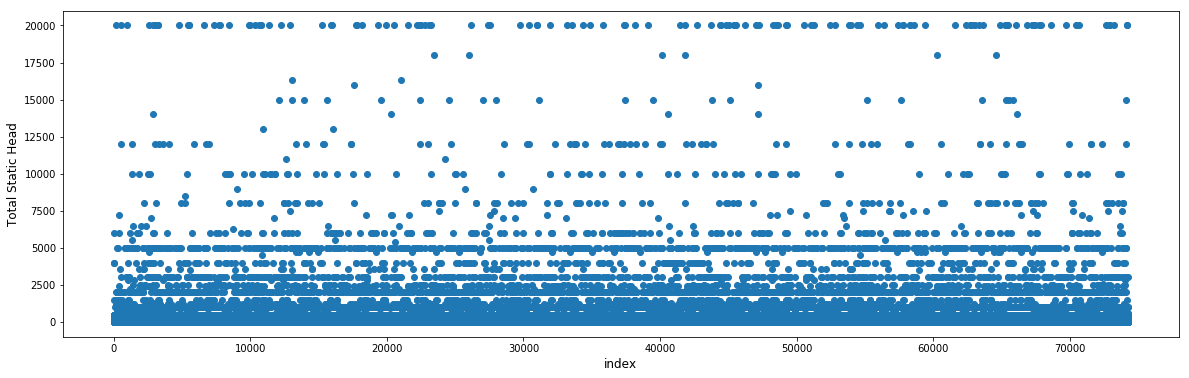

In [11]:
plt.figure(figsize=(20,6))
plt.scatter(range(df.shape[0]), df.amount_tsh.values)
plt.xlabel('index', fontsize=12)
plt.ylabel('Total Static Head', fontsize=12)
plt.show()

___

___

___

### The basin column
Looking at the unique values in combined as well as the train data frame and displaying their values.

In [12]:
print('Unique basin df:', len(df.basin.unique()), 'Unique basin train:', len(train.basin.unique()))
print('Nulls in basin:', len(df[df.basin.isnull()]))
print(df.basin.unique())

Unique basin df: 9 Unique basin train: 9
Nulls in basin: 0
['Lake Nyasa' 'Lake Victoria' 'Pangani' 'Ruvuma / Southern Coast'
 'Internal' 'Lake Tanganyika' 'Wami / Ruvu' 'Rufiji' 'Lake Rukwa']


It has just 9 values. These may be important for predicting condition of water pumps as the presence of basins and reservoirs does impact the amount and duration of water available at the pumps. However, these are categorical and have no defined ordinal property. The best way to treat such columns would be then to convert them to dummy variables and allow the prediction algortihm decide each one's importance. The code below takes care of converting to dummy variables.

In [13]:
df = pd.concat([df, pd.get_dummies(df.basin)], axis = 1 )
drop_cols_list = drop_cols_list.append(pd.Series( 'basin' ))
df.head(2)

,amount_tsh,basin,construction_year,date_recorded,district_code,extraction_type,extraction_type_class,extraction_type_group,funder,gps_height,id,installer,latitude,lga,longitude,management,management_group,num_private,payment,payment_type,permit,population,public_meeting,quality_group,quantity,quantity_group,recorded_by,region,region_code,scheme_management,scheme_name,source,source_class,source_type,subvillage,ward,water_quality,waterpoint_type,waterpoint_type_group,wpt_name,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,Wami / Ruvu
0,6000.0,Lake Nyasa,1999,2011-03-14,5,gravity,gravity,gravity,Roman,1390,NaN,Roman,-9.856322,Ludewa,34.938093,vwc,user-group,0,pay annually,annually,False,109,True,good,enough,enough,GeoData Consultants Ltd,Iringa,11,VWC,Roman,spring,groundwater,spring,Mnyusi B,Mundindi,soft,communal standpipe,communal standpipe,none,0,1,0,0,0,0,0,0,0
1,0.0,Lake Victoria,2010,2013-03-06,2,gravity,gravity,gravity,Grumeti,1399,NaN,GRUMETI,-2.147466,Serengeti,34.698766,wug,user-group,0,never pay,never pay,True,280,NaN,good,insufficient,insufficient,GeoData Consultants Ltd,Mara,20,Other,NaN,rainwater harvesting,surface,rainwater harvesting,Nyamara,Natta,soft,communal standpipe,communal standpipe,Zahanati,0,0,0,0,1,0,0,0,0


___

___

___

### The construction year
This field seems to be important.

The teechnology available at the time of construction will have an impact on it's usable life.

The pump's lock-in for maintenance procedures will alos be decided by the technology on which it was built.

Further, how long has the pump been in operation is also an important consideration.

At first I look at the earliest installed pump.

In [14]:
df[df.construction_year != 0]['construction_year'].min()

1960

Once I know the earliest date, it will provide a hint at imputing the missing values. This columns has several missing values but since it is an important predictor, we must not remove the column or impute values without analysis. Further, the number of years the pump has been in operation has a greater impact on the status than the year in which it was installed. We take this into account by creating a new column called years_operating. This column takes a difference between year of construction and the year the status was recorded. Thus, indirectly acocunting for the year of construction as well.

#### Imputing with mean or median results in several negative values. These might have meaning as the recording might be done while the pump was still under construction and thus the recorded value was impacted.
To best understand this, I checked the cross-validation score as well as the competition score for three ways of imputing the missing values - min(), mean() and median().

The min() gives the best results.

In [15]:
print('Unique years of construction:', df.construction_year.unique(), '\nMissing:', len(df[df.construction_year == 0]), '\nNulls:', len(df[df.construction_year.isnull()]))
print('Median w/o 0s:', df[df.construction_year!=0]['construction_year'].median(), 'Mean w/o 0s:', df[df.construction_year!=0]['construction_year'].mean())
print('Replacing')
df['construction_year'][df.construction_year == 0] = df['construction_year'][df.construction_year!=0].min()
print('Missing:', len(df[df.construction_year == 0]), '\nNulls:', len(df[df.construction_year.isnull()]))
print('Median w/o 0s:', df[df.construction_year!=0]['construction_year'].median(), 'Mean w/o 0s:', df[df.construction_year!=0]['construction_year'].mean())

print('\nUnique years of recording:', pd.to_datetime(df.date_recorded).dt.year.unique(), '\nMissing:', len(df[df.date_recorded == 0]), '\nNulls:', len(df[df.date_recorded.isnull()]))
df['years_operating'] = (pd.to_datetime(df.date_recorded).dt.year - df.construction_year)
print('Negative years of operation:', len(df[df.years_operating < 0]))

drop_cols_list = drop_cols_list.append(pd.Series( ['construction_year', 'date_recorded'] ))

Unique years of construction: [1999 2010 2009 1986    0 2011 1987 1991 1978 1992 2008 1974 2000 2002
 2004 1972 2003 1980 2007 1973 1985 1970 1995 2006 1962 2005 1997 2012
 1996 1977 1983 1984 1990 1982 1976 1988 1989 1975 1960 1961 1998 1963
 1971 1994 1968 1993 2001 1979 1967 2013 1969 1981 1964 1966 1965] 
Missing: 25969 
Nulls: 0
Median w/o 0s: 2000.0 Mean w/o 0s: 1996.8709430210642
Replacing
Missing: 0 
Nulls: 0
Median w/o 0s: 1986.0 Mean w/o 0s: 1983.9752996632997

Unique years of recording: [2011 2013 2012 2004 2002 2001] 
Missing: 0 
Nulls: 0
Negative years of operation: 12


___

___

___

### The district code
There are several columns which suggests a geographic input. These are region, region_code, district_code, lga, ward, subvillage, latitude, longitude and gps_height. Of all these columns, except for latitude, longitude and gps_height, other columns are a mix of geographic attributes as well as local government authority. Since the lat-long-ht combination is a good indicator of geographic positioning, Iassume the rest only for bringing the information on governance.

Further, understanding Tanzania's governance subdivisions is important. From publicly available information I understand that the country has the following organization starting from largest area and going to the smallest area.

#### Regions -> Districts -> Divisions -> Wards -> lga ~ subvillage

What is still missing is the information on lga and subvillage. Looking at the high number of unique values, I assume these are the smallest divisions of governance. I proceed with an assumption that the government body closest to the water pump will have a greatest impact on the quality and maintenance of the pump. Also, I hope this will take into account the effect of the larger governing bodies as the local bodies must be bound by laws and regulations of the divisional and regional bodies.

In [16]:
print('Unique district codes:', len(df.district_code.unique()))
print('Nulls:', df[df.district_code.isnull()]['district_code'].count())
print('Missing value:', df[df.district_code == 0]['district_code'].count())

dist_titles = pd.Series()
dist_dummies_frame = pd.get_dummies(df.district_code)
dist_dummies_cols = pd.Series()
for c in dist_dummies_frame.columns:
    dist_dummies_cols = dist_dummies_cols.append( pd.Series('dist_' + str(c)) )
dist_dummies_cols
dist_dummies_frame.columns = dist_dummies_cols
print(dist_dummies_frame.columns)

df = pd.concat([df, dist_dummies_frame], axis = 1 )
drop_cols_list = drop_cols_list.append(pd.Series( 'district_code' ))

Unique district codes: 20
Nulls: 0
Missing value: 27
Index(['dist_0', 'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'dist_7', 'dist_8', 'dist_13', 'dist_23', 'dist_30', 'dist_33',
       'dist_43', 'dist_53', 'dist_60', 'dist_62', 'dist_63', 'dist_67',
       'dist_80'],
      dtype='object')


I had tried with lga too in order to get an idea of what it's impact is.
There are many levels with no ordinal property. Hence, converting to dummies was the best option.
However, it negatively affects the prediction.

So it is best to remove this column. The other columns which provide similar information are also dropped.

In [17]:
drop_cols_list = drop_cols_list.append(pd.Series( ['region', 'region_code', 'ward', 'lga', 'subvillage'] ))

#print('Unique district codes:', len(df.lga.unique()))
#print('Nulls:', df[df.lga.isnull()]['lga'].count())
#print('Missing value:', df[df.lga == 0]['lga'].count())

#lga_titles = pd.Series()
#lga_dummies_frame = pd.get_dummies(df.lga)
#lga_dummies_cols = pd.Series()
#for c in lga_dummies_frame.columns:
#    lga_dummies_cols = lga_dummies_cols.append( pd.Series('dist_' + str(c)) )
#lga_dummies_cols
#lga_dummies_frame.columns = lga_dummies_cols
#print(lga_dummies_frame.columns)

#df = pd.concat([df, lga_dummies_frame], axis = 1 )
#df = df.drop('lga', axis = 1)

___

___

___

### The extraction_type family of columns
A summary below shows that they are very similar and hence keeping all of them is not useful.

I select the extraction_type as the columns which gives all the information required. Keeping or removing other two columns has no impact on the score of prediction.

In [18]:
print(df[['extraction_type', 'extraction_type_class', 'extraction_type_group']])
print(len(df.extraction_type.unique()))
print(len(df.extraction_type_class.unique()))
print(len(df.extraction_type_group.unique()))

et_dummies_frame = pd.get_dummies(df.extraction_type)
et_dummies_cols = pd.Series()
for c in et_dummies_frame.columns:
    et_dummies_cols = et_dummies_cols.append( pd.Series('et_' + str(c)) )
et_dummies_cols
et_dummies_frame.columns = et_dummies_cols
print(et_dummies_frame.columns)

df = pd.concat([df, et_dummies_frame], axis = 1 )
drop_cols_list = drop_cols_list.append(pd.Series( ['extraction_type','extraction_type_class', 'extraction_type_group'] ))

      extraction_type extraction_type_class extraction_type_group
0             gravity               gravity               gravity
1             gravity               gravity               gravity
2             gravity               gravity               gravity
3         submersible           submersible           submersible
4             gravity               gravity               gravity
5         submersible           submersible           submersible
6              swn 80              handpump                swn 80
7         nira/tanira              handpump           nira/tanira
8       india mark ii              handpump         india mark ii
9         nira/tanira              handpump           nira/tanira
10        submersible           submersible           submersible
11             swn 80              handpump                swn 80
12        nira/tanira              handpump           nira/tanira
13            gravity               gravity               gravity
14        

In [19]:
df.head(2)

,amount_tsh,basin,construction_year,date_recorded,district_code,extraction_type,extraction_type_class,extraction_type_group,funder,gps_height,id,installer,latitude,lga,longitude,management,management_group,num_private,payment,payment_type,permit,population,public_meeting,quality_group,quantity,quantity_group,recorded_by,region,region_code,scheme_management,scheme_name,source,source_class,source_type,subvillage,ward,water_quality,waterpoint_type,waterpoint_type_group,wpt_name,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,Wami / Ruvu,years_operating,dist_0,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,dist_8,dist_13,dist_23,dist_30,dist_33,dist_43,dist_53,dist_60,dist_62,dist_63,dist_67,dist_80,et_afridev,et_cemo,et_climax,et_gravity,et_india mark ii,et_india mark iii,et_ksb,et_mono,et_nira/tanira,et_other,et_other - mkulima/shinyanga,et_other - play pump,et_other - rope pump,et_other - swn 81,et_submersible,et_swn 80,et_walimi,et_windmill
0,6000.0,Lake Nyasa,1999,2011-03-14,5,gravity,gravity,gravity,Roman,1390,NaN,Roman,-9.856322,Ludewa,34.938093,vwc,user-group,0,pay annually,annually,False,109,True,good,enough,enough,GeoData Consultants Ltd,Iringa,11,VWC,Roman,spring,groundwater,spring,Mnyusi B,Mundindi,soft,communal standpipe,communal standpipe,none,0,1,0,0,0,0,0,0,0,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,Lake Victoria,2010,2013-03-06,2,gravity,gravity,gravity,Grumeti,1399,NaN,GRUMETI,-2.147466,Serengeti,34.698766,wug,user-group,0,never pay,never pay,True,280,NaN,good,insufficient,insufficient,GeoData Consultants Ltd,Mara,20,Other,NaN,rainwater harvesting,surface,rainwater harvesting,Nyamara,Natta,soft,communal standpipe,communal standpipe,Zahanati,0,0,0,0,1,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


___

___

___

In [20]:
drop_cols_list = drop_cols_list.append(pd.Series( 'funder' ))

___

___

___

### Management group of columns 
#### management, management_group, scheme_management and scheme_name
A large majority of pumps fall under one type. I found it was best to assign a boolean value of whether it is under this group or not for both columns

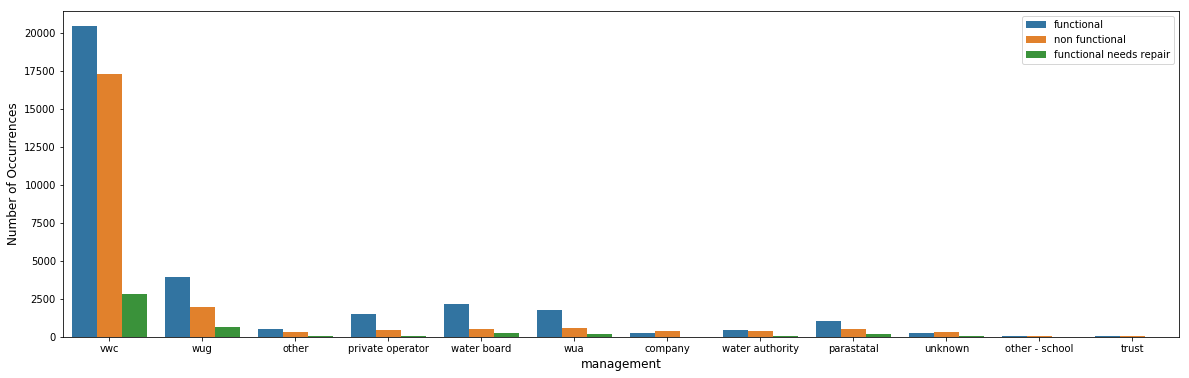

In [21]:
plt.figure(figsize=(20,6))
sns.countplot(train['management'], hue = labels['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('management', fontsize=12)
plt.show()

In [22]:
df.management = df.management == 'vwc'
df.head(2)

,amount_tsh,basin,construction_year,date_recorded,district_code,extraction_type,extraction_type_class,extraction_type_group,funder,gps_height,id,installer,latitude,lga,longitude,management,management_group,num_private,payment,payment_type,permit,population,public_meeting,quality_group,quantity,quantity_group,recorded_by,region,region_code,scheme_management,scheme_name,source,source_class,source_type,subvillage,ward,water_quality,waterpoint_type,waterpoint_type_group,wpt_name,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,Wami / Ruvu,years_operating,dist_0,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,dist_8,dist_13,dist_23,dist_30,dist_33,dist_43,dist_53,dist_60,dist_62,dist_63,dist_67,dist_80,et_afridev,et_cemo,et_climax,et_gravity,et_india mark ii,et_india mark iii,et_ksb,et_mono,et_nira/tanira,et_other,et_other - mkulima/shinyanga,et_other - play pump,et_other - rope pump,et_other - swn 81,et_submersible,et_swn 80,et_walimi,et_windmill
0,6000.0,Lake Nyasa,1999,2011-03-14,5,gravity,gravity,gravity,Roman,1390,NaN,Roman,-9.856322,Ludewa,34.938093,True,user-group,0,pay annually,annually,False,109,True,good,enough,enough,GeoData Consultants Ltd,Iringa,11,VWC,Roman,spring,groundwater,spring,Mnyusi B,Mundindi,soft,communal standpipe,communal standpipe,none,0,1,0,0,0,0,0,0,0,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,Lake Victoria,2010,2013-03-06,2,gravity,gravity,gravity,Grumeti,1399,NaN,GRUMETI,-2.147466,Serengeti,34.698766,False,user-group,0,never pay,never pay,True,280,NaN,good,insufficient,insufficient,GeoData Consultants Ltd,Mara,20,Other,NaN,rainwater harvesting,surface,rainwater harvesting,Nyamara,Natta,soft,communal standpipe,communal standpipe,Zahanati,0,0,0,0,1,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


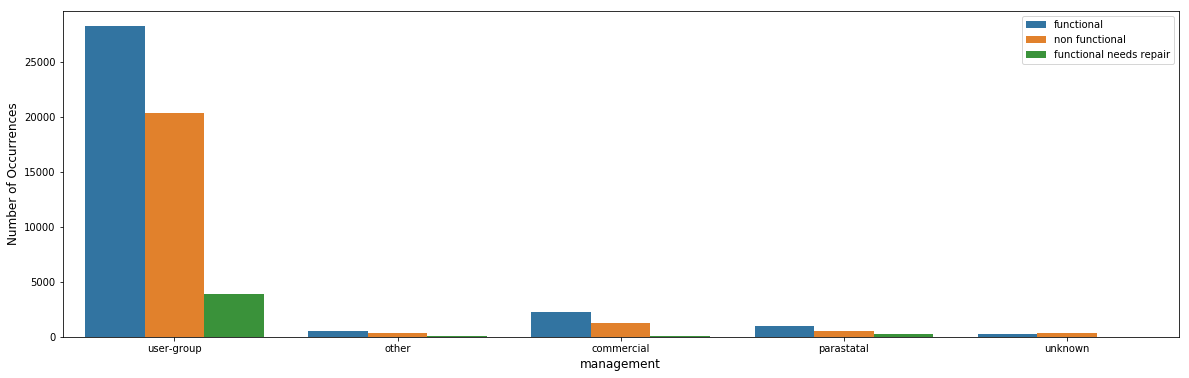

In [23]:
plt.figure(figsize=(20,6))
sns.countplot(train['management_group'], hue = labels['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('management', fontsize=12)
plt.show()

In [24]:
df.management_group = df.management_group == 'user-group'
df.head(2)

,amount_tsh,basin,construction_year,date_recorded,district_code,extraction_type,extraction_type_class,extraction_type_group,funder,gps_height,id,installer,latitude,lga,longitude,management,management_group,num_private,payment,payment_type,permit,population,public_meeting,quality_group,quantity,quantity_group,recorded_by,region,region_code,scheme_management,scheme_name,source,source_class,source_type,subvillage,ward,water_quality,waterpoint_type,waterpoint_type_group,wpt_name,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,Wami / Ruvu,years_operating,dist_0,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,dist_8,dist_13,dist_23,dist_30,dist_33,dist_43,dist_53,dist_60,dist_62,dist_63,dist_67,dist_80,et_afridev,et_cemo,et_climax,et_gravity,et_india mark ii,et_india mark iii,et_ksb,et_mono,et_nira/tanira,et_other,et_other - mkulima/shinyanga,et_other - play pump,et_other - rope pump,et_other - swn 81,et_submersible,et_swn 80,et_walimi,et_windmill
0,6000.0,Lake Nyasa,1999,2011-03-14,5,gravity,gravity,gravity,Roman,1390,NaN,Roman,-9.856322,Ludewa,34.938093,True,True,0,pay annually,annually,False,109,True,good,enough,enough,GeoData Consultants Ltd,Iringa,11,VWC,Roman,spring,groundwater,spring,Mnyusi B,Mundindi,soft,communal standpipe,communal standpipe,none,0,1,0,0,0,0,0,0,0,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,Lake Victoria,2010,2013-03-06,2,gravity,gravity,gravity,Grumeti,1399,NaN,GRUMETI,-2.147466,Serengeti,34.698766,False,True,0,never pay,never pay,True,280,NaN,good,insufficient,insufficient,GeoData Consultants Ltd,Mara,20,Other,NaN,rainwater harvesting,surface,rainwater harvesting,Nyamara,Natta,soft,communal standpipe,communal standpipe,Zahanati,0,0,0,0,1,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


From the graph below, scheme_mangement is providing same informaiton as management.
The scheme_name has too many levels and has no direct relation with operation of the pump.

It is better to drop these two columns.

Unique scheme_name 2869


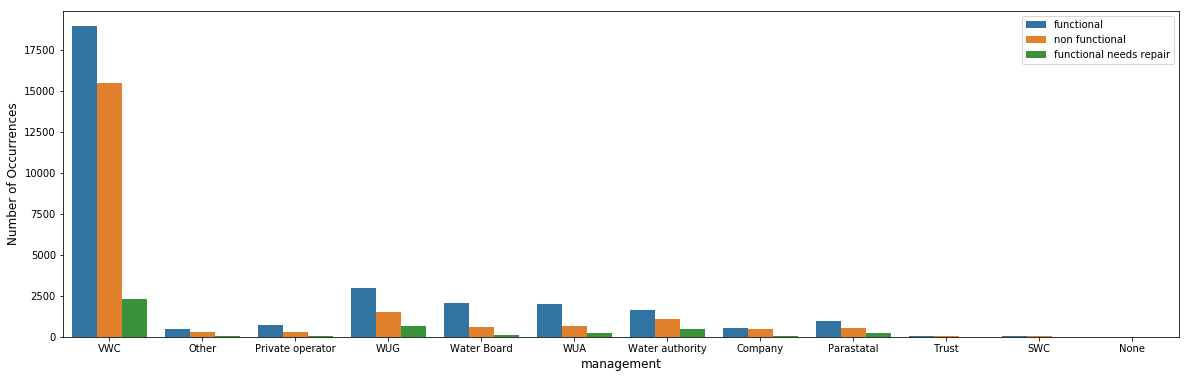

In [25]:
drop_cols_list = drop_cols_list.append(pd.Series( ['scheme_management', 'scheme_name'] ))
print('Unique scheme_name', len(df.scheme_name.unique()))
plt.figure(figsize=(20,6))
sns.countplot(train['scheme_management'], hue = labels['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('management', fontsize=12)
plt.show()

___

___

___

### payment and payment_type
Same approach as the management group of columns above.

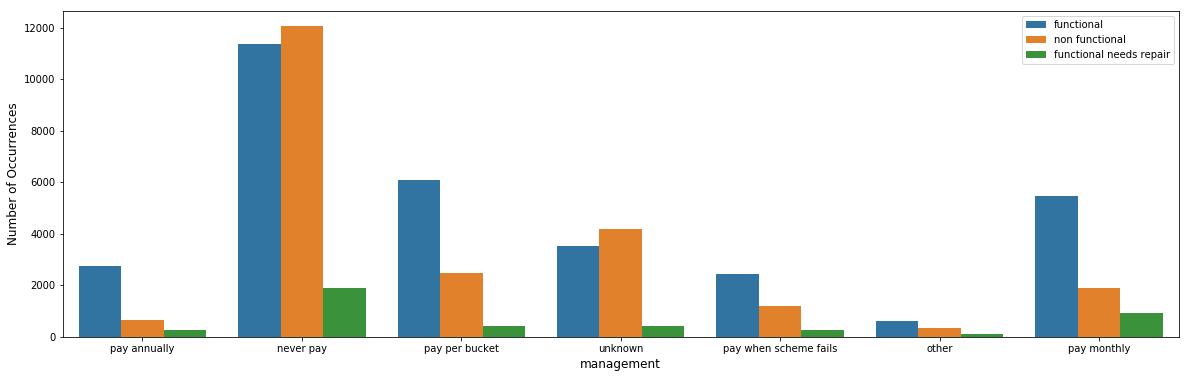

In [26]:
plt.figure(figsize=(20,6))
sns.countplot(train['payment'], hue = labels['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('management', fontsize=12)
plt.show()

In [27]:
df.payment = df.payment == 'never pay'
df.head(2)

,amount_tsh,basin,construction_year,date_recorded,district_code,extraction_type,extraction_type_class,extraction_type_group,funder,gps_height,id,installer,latitude,lga,longitude,management,management_group,num_private,payment,payment_type,permit,population,public_meeting,quality_group,quantity,quantity_group,recorded_by,region,region_code,scheme_management,scheme_name,source,source_class,source_type,subvillage,ward,water_quality,waterpoint_type,waterpoint_type_group,wpt_name,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,Wami / Ruvu,years_operating,dist_0,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,dist_8,dist_13,dist_23,dist_30,dist_33,dist_43,dist_53,dist_60,dist_62,dist_63,dist_67,dist_80,et_afridev,et_cemo,et_climax,et_gravity,et_india mark ii,et_india mark iii,et_ksb,et_mono,et_nira/tanira,et_other,et_other - mkulima/shinyanga,et_other - play pump,et_other - rope pump,et_other - swn 81,et_submersible,et_swn 80,et_walimi,et_windmill
0,6000.0,Lake Nyasa,1999,2011-03-14,5,gravity,gravity,gravity,Roman,1390,NaN,Roman,-9.856322,Ludewa,34.938093,True,True,0,False,annually,False,109,True,good,enough,enough,GeoData Consultants Ltd,Iringa,11,VWC,Roman,spring,groundwater,spring,Mnyusi B,Mundindi,soft,communal standpipe,communal standpipe,none,0,1,0,0,0,0,0,0,0,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.0,Lake Victoria,2010,2013-03-06,2,gravity,gravity,gravity,Grumeti,1399,NaN,GRUMETI,-2.147466,Serengeti,34.698766,False,True,0,True,never pay,True,280,NaN,good,insufficient,insufficient,GeoData Consultants Ltd,Mara,20,Other,NaN,rainwater harvesting,surface,rainwater harvesting,Nyamara,Natta,soft,communal standpipe,communal standpipe,Zahanati,0,0,0,0,1,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
drop_cols_list = drop_cols_list.append(pd.Series( ['payment_type'] ))

___

___

___

### permit column
We do not know much about this column but might indicate the permission to operate. Since it is a boolean with few missing values. It is best to impute the missing values.

In [29]:
print('Missing values for permit:', len(df[df.permit.isnull()]))
df['permit'][df.permit.isnull()] = False

Missing values for permit: 3793


___

___

___

### public_meeting column
Same approach as for permit column.

In [30]:
print(len(df[df.public_meeting.isnull()]))
df['public_meeting'][df.public_meeting.isnull()] = False

4155


___

___

___

### quality_group column
Data present in this column has a similar distribution as seen for management group of columns.

Hence, the same approach for this column as well

In [31]:
df.quality_group.unique()

array(['good', 'salty', 'milky', 'unknown', 'fluoride', 'colored'],
      dtype=object)

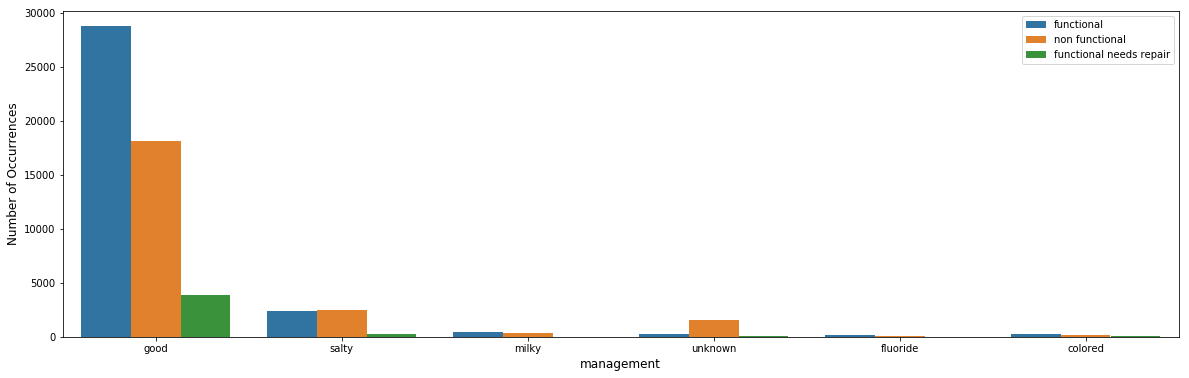

In [32]:
plt.figure(figsize=(20,6))
sns.countplot(train['quality_group'], hue = labels['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('management', fontsize=12)
plt.show()

In [33]:
df.quality_group = df.quality_group == 'good'

___

___

___

### Columns related to quantity
There are two columns with same information. I remove one column.

The distribution is skewed but different categories have significant number of rows. Cannot convert this column to boolean as doing so might remove some important information.

Also, they have inherent ordinal property. So it is best to encode them as integer levels in place of string categories.

In [34]:
print('Unique values in quantity column:', df.quantity.unique())
print('Unique values in quantity_group column:', df.quantity_group.unique())

Unique values in quantity column: ['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
Unique values in quantity_group column: ['enough' 'insufficient' 'dry' 'seasonal' 'unknown']


In [35]:
drop_cols_list = drop_cols_list.append(pd.Series( 'quantity_group' ))

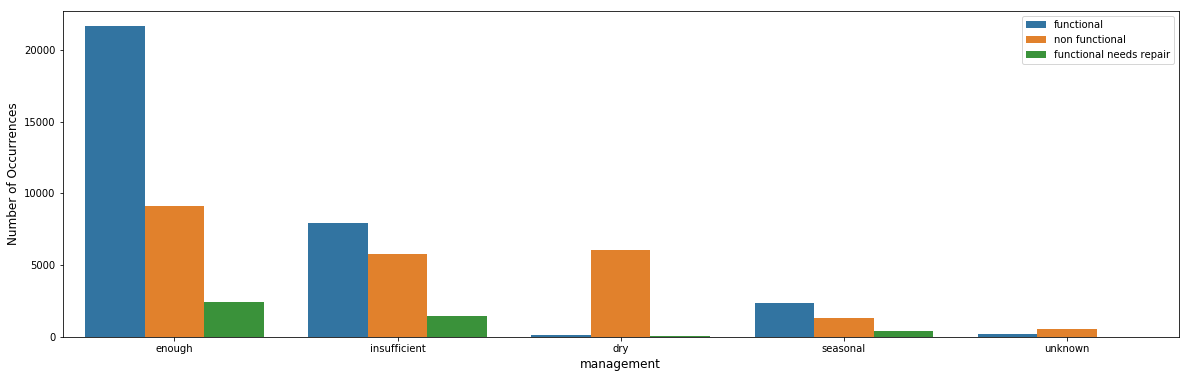

In [36]:
plt.figure(figsize=(20,6))
sns.countplot(train['quantity'], hue = labels['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('management', fontsize=12)
plt.show()

In [37]:
def quantity_encode(val):
    if val == 'enough':
        return 4
    elif val == 'insufficient':
        return 3
    elif val == 'dry':
        return 2
    else:
        return 1
    
df['qty'] = df.quantity.apply(quantity_encode)

In [38]:
drop_cols_list = drop_cols_list.append(pd.Series( 'quantity' ))

___

___

___

### waterpoint_type, waterpoint_type_group and wpt_name
wpt_name is only a name and has little bearance with status of the pump. I remove this column for predictions.

waterpoint_type_group and waterpoint_typre have string levels with skewed distribution. It might have ordinal properties so I encode it with integer levels. The two columns provide same information albeit with waterpoint_type having one extra level in comparison. I keep the one with higher number of levels.

In [39]:
drop_cols_list = drop_cols_list.append(pd.Series( ['waterpoint_type_group', 'wpt_name'] ))
df.head(2)

,amount_tsh,basin,construction_year,date_recorded,district_code,extraction_type,extraction_type_class,extraction_type_group,funder,gps_height,id,installer,latitude,lga,longitude,management,management_group,num_private,payment,payment_type,permit,population,public_meeting,quality_group,quantity,quantity_group,recorded_by,region,region_code,scheme_management,scheme_name,source,source_class,source_type,subvillage,ward,water_quality,waterpoint_type,waterpoint_type_group,wpt_name,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,Wami / Ruvu,years_operating,dist_0,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,dist_8,dist_13,dist_23,dist_30,dist_33,dist_43,dist_53,dist_60,dist_62,dist_63,dist_67,dist_80,et_afridev,et_cemo,et_climax,et_gravity,et_india mark ii,et_india mark iii,et_ksb,et_mono,et_nira/tanira,et_other,et_other - mkulima/shinyanga,et_other - play pump,et_other - rope pump,et_other - swn 81,et_submersible,et_swn 80,et_walimi,et_windmill,qty
0,6000.0,Lake Nyasa,1999,2011-03-14,5,gravity,gravity,gravity,Roman,1390,NaN,Roman,-9.856322,Ludewa,34.938093,True,True,0,False,annually,False,109,True,True,enough,enough,GeoData Consultants Ltd,Iringa,11,VWC,Roman,spring,groundwater,spring,Mnyusi B,Mundindi,soft,communal standpipe,communal standpipe,none,0,1,0,0,0,0,0,0,0,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
1,0.0,Lake Victoria,2010,2013-03-06,2,gravity,gravity,gravity,Grumeti,1399,NaN,GRUMETI,-2.147466,Serengeti,34.698766,False,True,0,True,never pay,True,280,False,True,insufficient,insufficient,GeoData Consultants Ltd,Mara,20,Other,NaN,rainwater harvesting,surface,rainwater harvesting,Nyamara,Natta,soft,communal standpipe,communal standpipe,Zahanati,0,0,0,0,1,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


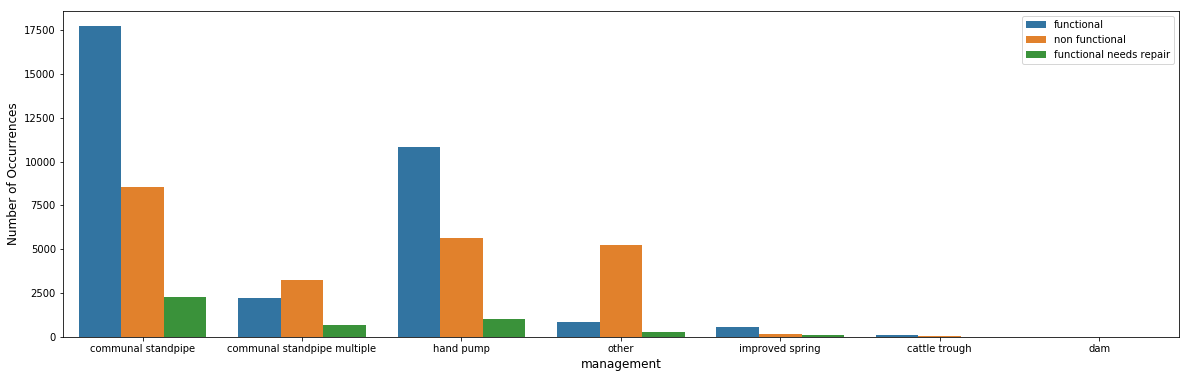

In [40]:
plt.figure(figsize=(20,6))
sns.countplot(train['waterpoint_type'], hue = labels['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('management', fontsize=12)
plt.show()

In [41]:
df.waterpoint_type.unique()

array(['communal standpipe', 'communal standpipe multiple', 'hand pump',
       'other', 'improved spring', 'cattle trough', 'dam'], dtype=object)

In [42]:
def waterpointtype_encode(val):
    if val == 'communal standpipe':
        return 5
    elif val == 'hand pump':
        return 4
    elif val == 'communal standpipe multiple':
        return 3
    elif val == 'other':
        return 2
    else:
        return 1
    
df['wpt_type'] = df.waterpoint_type.apply(waterpointtype_encode)

In [43]:
drop_cols_list = drop_cols_list.append(pd.Series( 'waterpoint_type' ))

___

___

___

### water_quality
Similar structure as one found for management group above. Same treatment.

In [44]:
df.water_quality.unique()

array(['soft', 'salty', 'milky', 'unknown', 'fluoride', 'coloured',
       'salty abandoned', 'fluoride abandoned'], dtype=object)

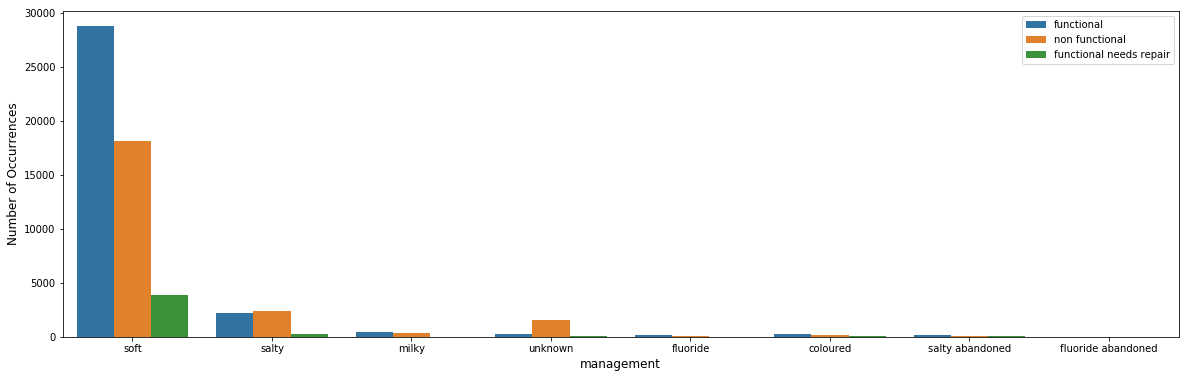

In [45]:
plt.figure(figsize=(20,6))
sns.countplot(train['water_quality'], hue = labels['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('management', fontsize=12)
plt.show()

In [46]:
df.water_quality = df.water_quality == 'soft'

___

___

___

### source group of columns
### source, source_class and source_type
Similar and related information but with different number of levels and different distribution.

source -> encoded

source_type -> encoded

source_class -> converted too boolean (groundwater or not)

In [47]:
df[['source', 'source_class', 'source_type']].head(2)

,source,source_class,source_type
0,spring,groundwater,spring
1,rainwater harvesting,surface,rainwater harvesting


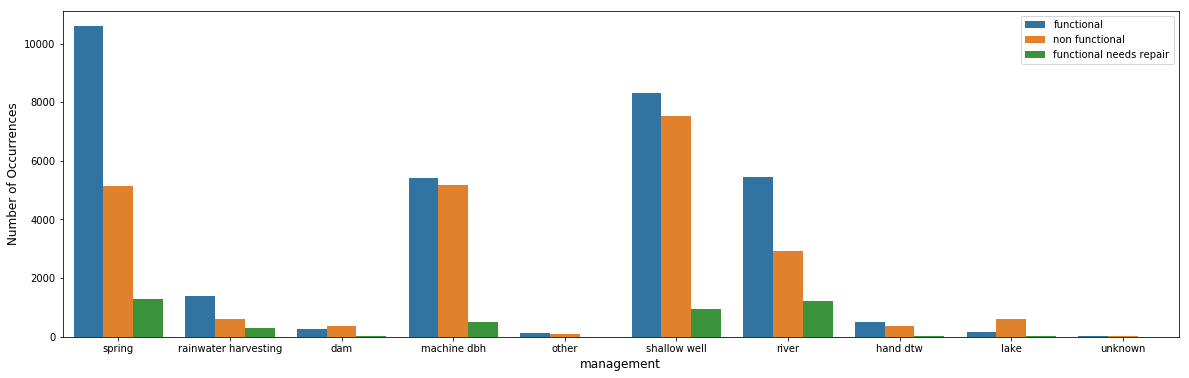

In [48]:
plt.figure(figsize=(20,6))
sns.countplot(train['source'], hue = labels['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('management', fontsize=12)
plt.show()

In [49]:
def source_encode(val):
    if val == 'spring':
        return 5
    elif val == 'shallow well':
        return 4
    elif val == 'machine dbh':
        return 3
    elif val == 'river':
        return 2
    else:
        return 1
    
df.source = df.source.apply(source_encode)

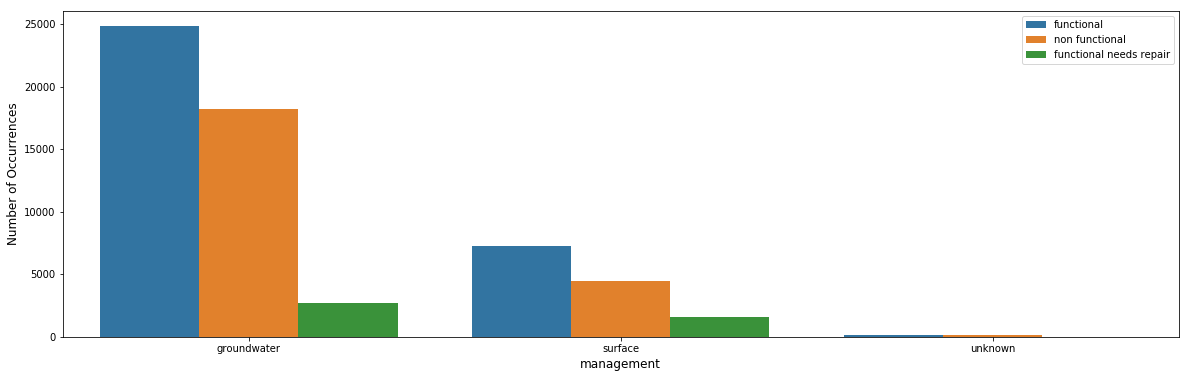

In [50]:
plt.figure(figsize=(20,6))
sns.countplot(train['source_class'], hue = labels['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('management', fontsize=12)
plt.show()

In [51]:
df.source_class = df.source_class == 'groundwater'

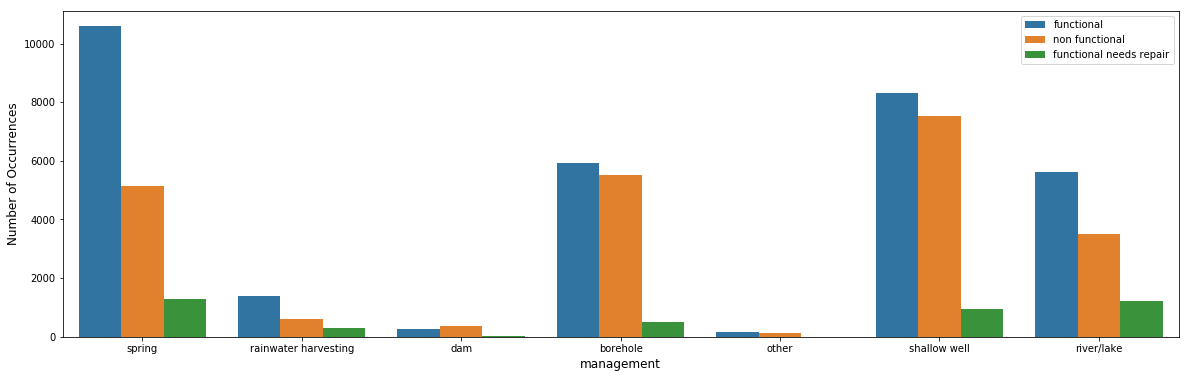

In [52]:
plt.figure(figsize=(20,6))
sns.countplot(train['source_type'], hue = labels['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('management', fontsize=12)
plt.show()

In [53]:
def sourcetype_encode(val):
    if val == 'spring':
        return 5
    elif val == 'shallow well':
        return 4
    elif val == 'borehole':
        return 3
    elif val == 'river/lake':
        return 2
    else:
        return 1
    
df.source_type = df.source_type.apply(sourcetype_encode)

___

___

___

### installer
Does not provide much information or improve prediction score. Removed.

In [54]:
drop_cols_list = drop_cols_list.append(pd.Series( 'installer' ))

In [55]:
df.head(2)

,amount_tsh,basin,construction_year,date_recorded,district_code,extraction_type,extraction_type_class,extraction_type_group,funder,gps_height,id,installer,latitude,lga,longitude,management,management_group,num_private,payment,payment_type,permit,population,public_meeting,quality_group,quantity,quantity_group,recorded_by,region,region_code,scheme_management,scheme_name,source,source_class,source_type,subvillage,ward,water_quality,waterpoint_type,waterpoint_type_group,wpt_name,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,Wami / Ruvu,years_operating,dist_0,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,dist_8,dist_13,dist_23,dist_30,dist_33,dist_43,dist_53,dist_60,dist_62,dist_63,dist_67,dist_80,et_afridev,et_cemo,et_climax,et_gravity,et_india mark ii,et_india mark iii,et_ksb,et_mono,et_nira/tanira,et_other,et_other - mkulima/shinyanga,et_other - play pump,et_other - rope pump,et_other - swn 81,et_submersible,et_swn 80,et_walimi,et_windmill,qty,wpt_type
0,6000.0,Lake Nyasa,1999,2011-03-14,5,gravity,gravity,gravity,Roman,1390,NaN,Roman,-9.856322,Ludewa,34.938093,True,True,0,False,annually,False,109,True,True,enough,enough,GeoData Consultants Ltd,Iringa,11,VWC,Roman,5,True,5,Mnyusi B,Mundindi,True,communal standpipe,communal standpipe,none,0,1,0,0,0,0,0,0,0,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5
1,0.0,Lake Victoria,2010,2013-03-06,2,gravity,gravity,gravity,Grumeti,1399,NaN,GRUMETI,-2.147466,Serengeti,34.698766,False,True,0,True,never pay,True,280,False,True,insufficient,insufficient,GeoData Consultants Ltd,Mara,20,Other,NaN,1,False,1,Nyamara,Natta,True,communal standpipe,communal standpipe,Zahanati,0,0,0,0,1,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5


___

___

___

### longitude, latitude, gps_height
Longitude and latitude has many missing values denoted by 0. Lat-Long 0, 0 is not in Tanzania.
Imputation done by using median values from non-zero entries to bring these points at least within Tanzania.

gps_height zero might have some meaning as there are several points on land and water bodies within Tanzania which are above or below sea level. However, there is a strong correlation with lat-long being zero for the values of gps_height being zero. These can be considered as missing observations.

Imputing missing gps_height to median value gives better prediction score.

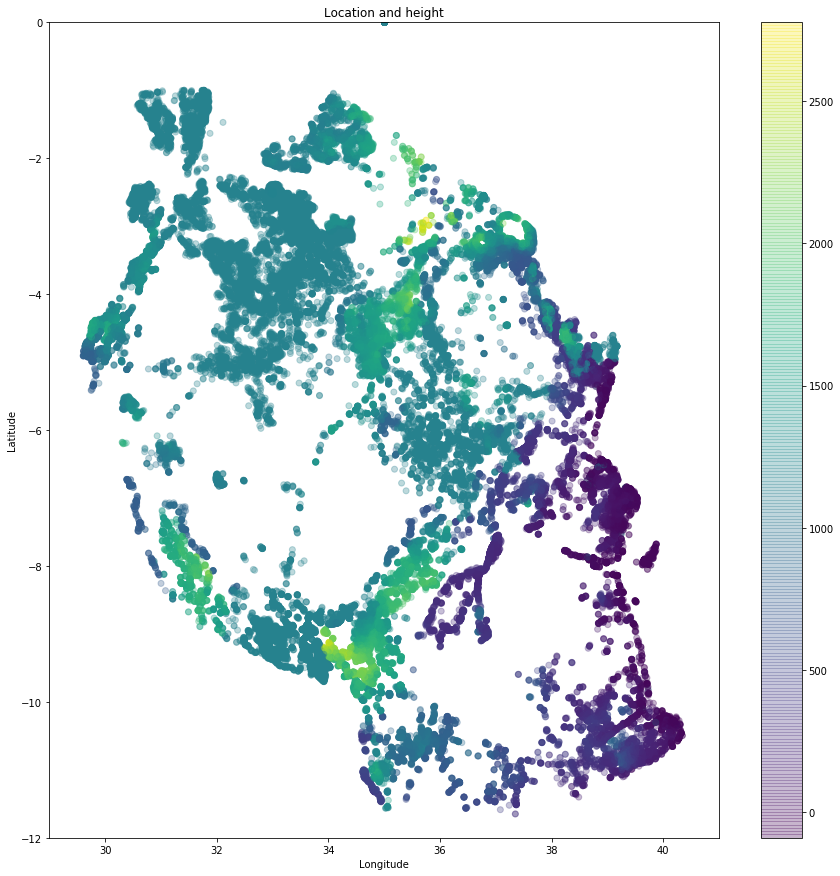

In [56]:
df['gps_height'][df.gps_height == 0] = df['gps_height'][df.gps_height!=0].median()
df['latitude'][df.latitude == 0] = df['latitude'][df.latitude!=0].median()
df['longitude'][df.longitude == 0] = df['longitude'][df.longitude!=0].median()

plt.figure(figsize=(15, 15))
plt.scatter(y = df.latitude,
            x = df.longitude,
            c = df.gps_height,
            cmap = 'viridis',
            alpha = 0.3)
plt.colorbar()
plt.ylim(-12, 0)
plt.title('Location and height')
plt.ylabel('Latitude')
plt.xlim(29, 41)
plt.xlabel('Longitude')
plt.show()

___

___

___

## All columns have been treated at this point
We only need to drop the list columns to drop and run model.

### Before running models
Since I now have almost all data in numeric form, let's look at the correlation between different variables.

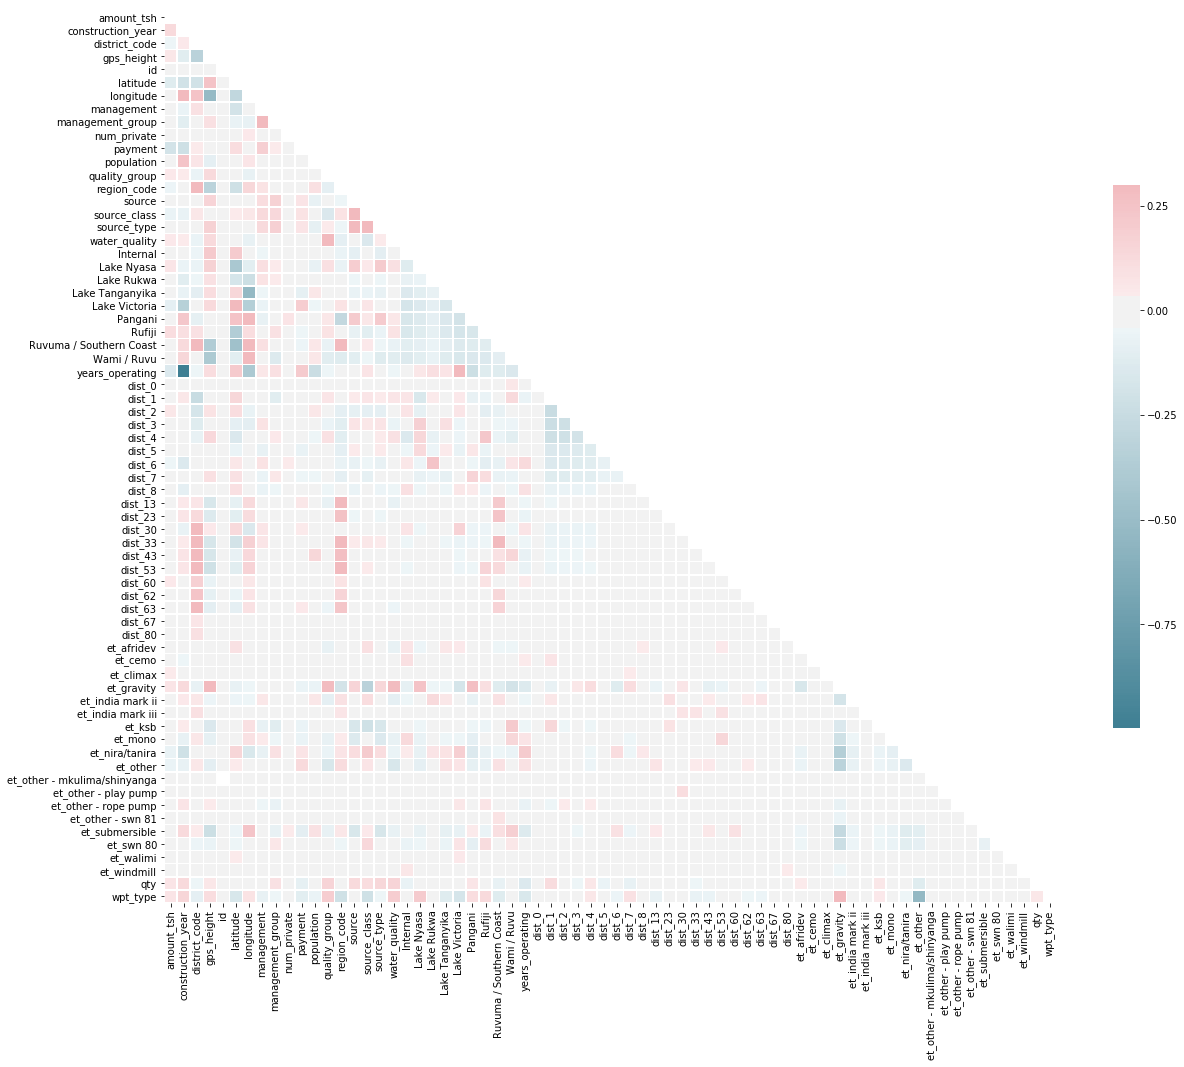

In [57]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [58]:
df_wo_dropped_cols = df

In [59]:
# list of columns to drop
drop_cols_list

0                       id
0              recorded_by
1              num_private
0                    basin
0        construction_year
1            date_recorded
0            district_code
0                   region
1              region_code
2                     ward
3                      lga
4               subvillage
0          extraction_type
1    extraction_type_class
2    extraction_type_group
0                   funder
0        scheme_management
1              scheme_name
0             payment_type
0           quantity_group
0                 quantity
0    waterpoint_type_group
1                 wpt_name
0          waterpoint_type
0                installer
dtype: object

In [60]:
df = df.drop(drop_cols_list, axis = 1)
df.head(2)

,amount_tsh,gps_height,latitude,longitude,management,management_group,payment,permit,population,public_meeting,quality_group,source,source_class,source_type,water_quality,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,Wami / Ruvu,years_operating,dist_0,dist_1,dist_2,dist_3,dist_4,dist_5,dist_6,dist_7,dist_8,dist_13,dist_23,dist_30,dist_33,dist_43,dist_53,dist_60,dist_62,dist_63,dist_67,dist_80,et_afridev,et_cemo,et_climax,et_gravity,et_india mark ii,et_india mark iii,et_ksb,et_mono,et_nira/tanira,et_other,et_other - mkulima/shinyanga,et_other - play pump,et_other - rope pump,et_other - swn 81,et_submersible,et_swn 80,et_walimi,et_windmill,qty,wpt_type
0,6000.0,1390,-9.856322,34.938093,True,True,False,False,109,True,True,5,True,5,True,0,1,0,0,0,0,0,0,0,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,5
1,0.0,1399,-2.147466,34.698766,False,True,True,True,280,False,True,1,False,1,True,0,0,0,0,1,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5


___

### Some algorithms don't automatically recognize these boolean columns

In [61]:
df.permit = df.permit.astype('bool')
df.public_meeting = df.public_meeting.astype('bool')

___

___

___

### Train-test split from the merged data frame df

In [62]:
train = df.iloc[:59400,:]
test = df.iloc[59400:,:]

To get ids of test set.

In [63]:
test1 = pd.read_csv("Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv")
test1.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe


___

___

___

### Running the prediction models on the data we have now

In [64]:
classifier_list = [LogisticRegression(solver='lbfgs', multi_class='multinomial', C = 3000, tol = 0.0001),
                  KNeighborsClassifier(n_neighbors = 15),
                  GaussianNB(),
                  GradientBoostingClassifier(n_estimators=500, learning_rate=1.0, random_state=10),
                  XGBClassifier(),
                  RandomForestClassifier(n_estimators=500, random_state = 8)]

In [65]:
for classifier in classifier_list:
    classifier.fit(train, labels['status_group'])
    Score = cross_val_score(classifier, train, labels['status_group'], scoring = 'accuracy',cv=5).mean()
    print(Score, 'for\n', classifier, '\n\n')

0.5976268231330889 for
 LogisticRegression(C=3000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False) 


0.6954036934285095 for
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform') 


0.4993776160119567 for
 GaussianNB(priors=None) 


0.7737371918281941 for
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=10, subsample=1.0, verbose=0,

___

___

___

### What is the effect on scaling the variables?

In [66]:
df = df_wo_dropped_cols
df = df.drop(drop_cols_list, axis = 1)
df.permit = df.permit.astype('bool')
df.public_meeting = df.public_meeting.astype('bool')
train = df.iloc[:59400,:]
test = df.iloc[59400:,:]

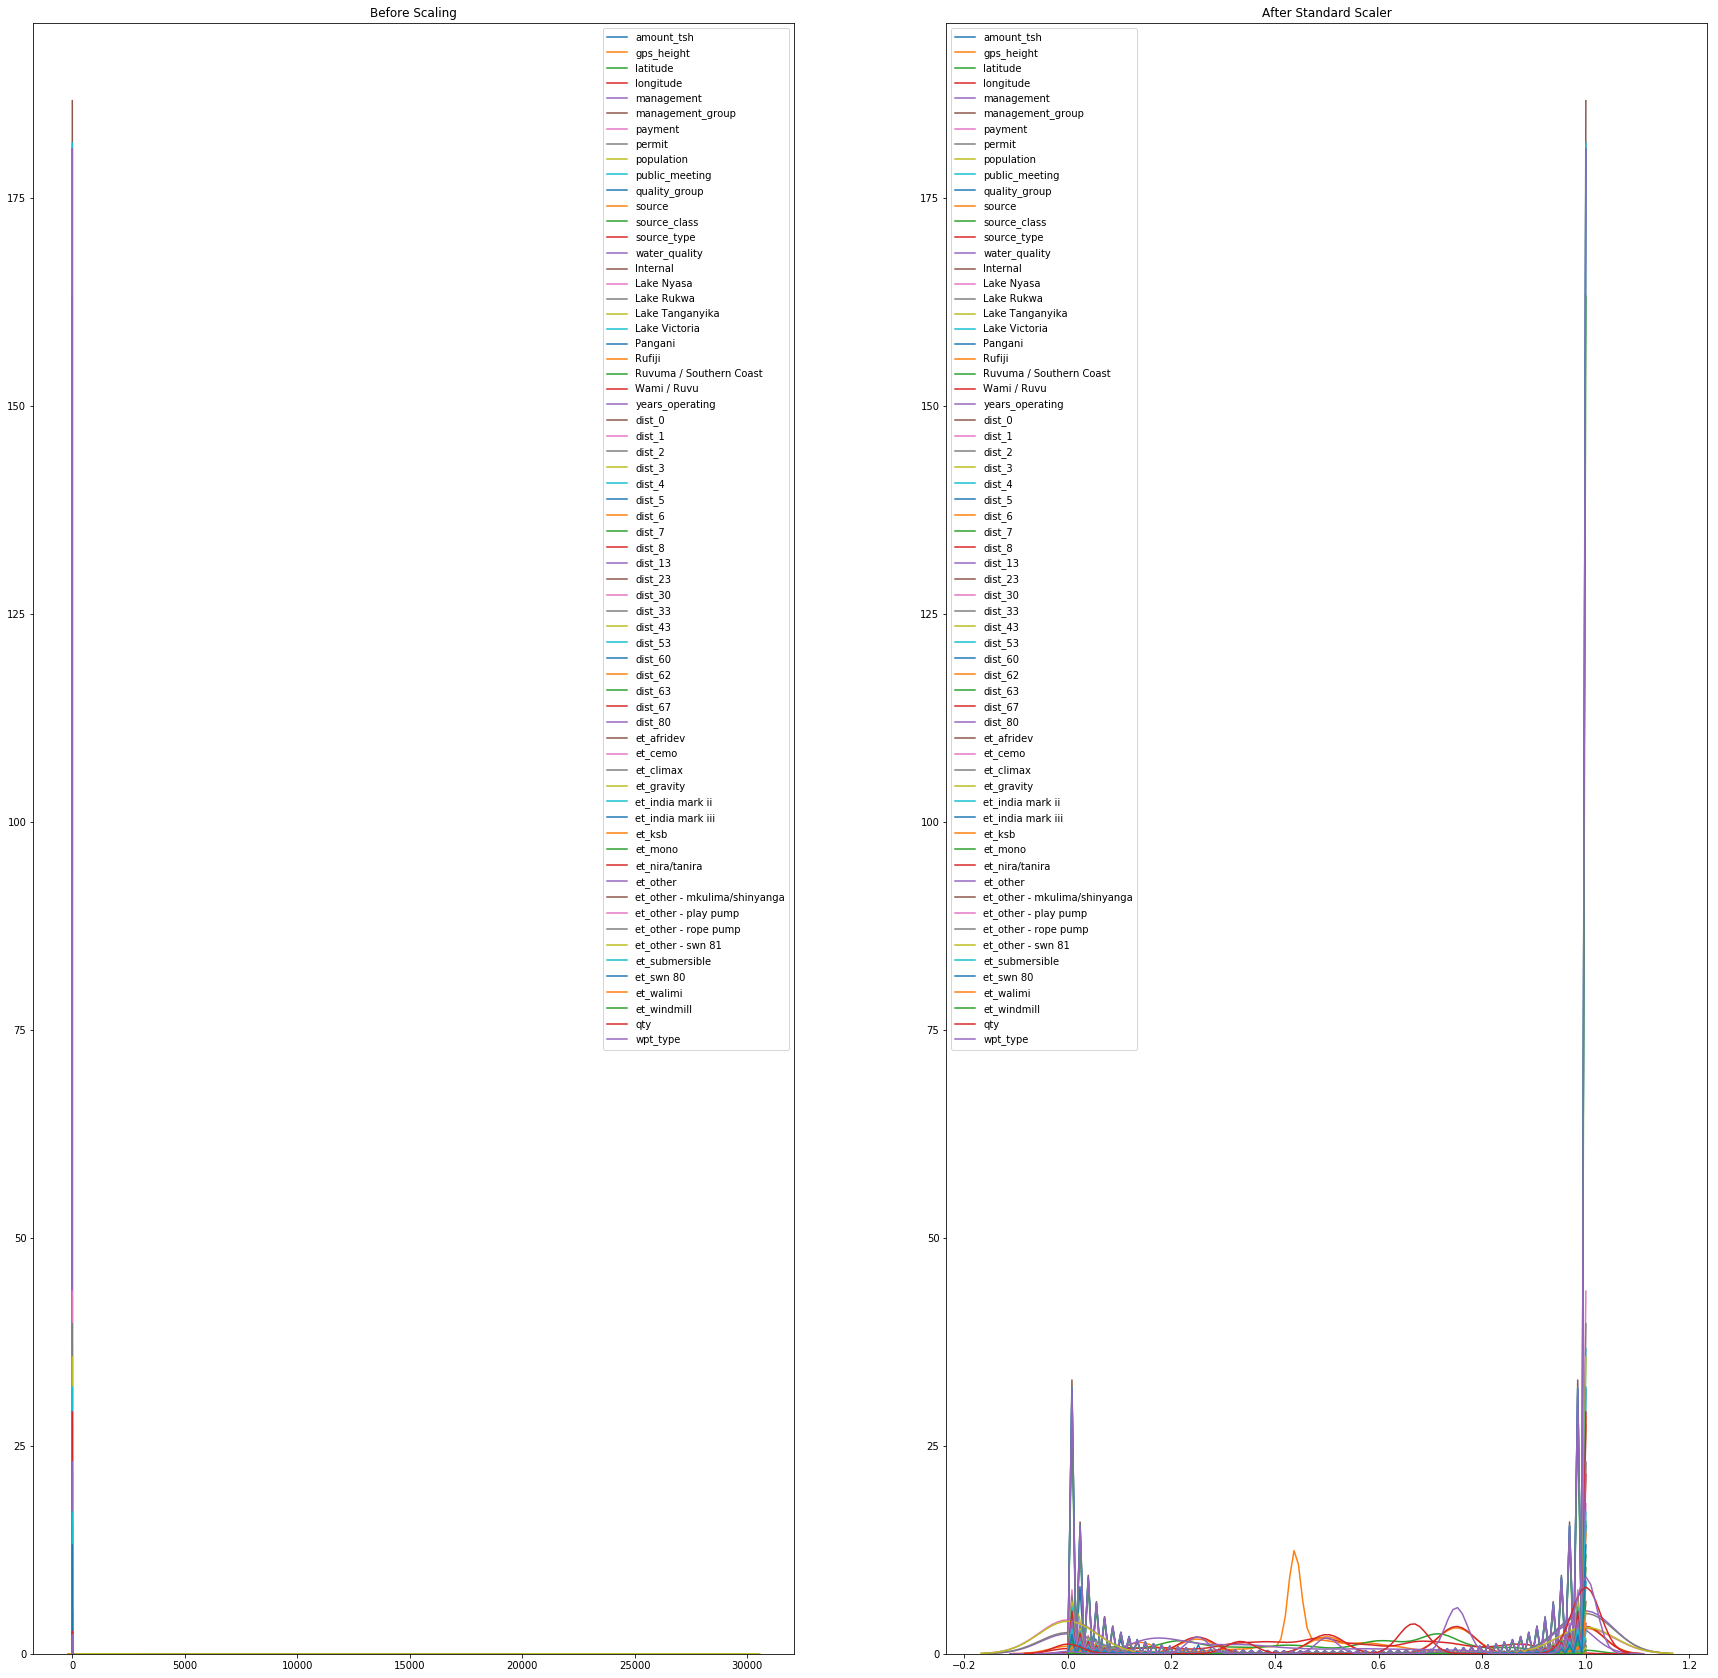

In [67]:
scaler = preprocessing.MinMaxScaler()
scaled_df = scaler.fit_transform(df)
scaled_df

scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
scaled_df.columns == df.columns
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(30, 30))

ax1.set_title('Before Scaling')
for c in df.columns:
    sns.kdeplot(df[c], ax=ax1)
ax2.set_title('After Standard Scaler')
for c in scaled_df.columns:
    sns.kdeplot(scaled_df[c], ax=ax2)
plt.show()

df = scaled_df

In [68]:
for classifier in classifier_list:
    classifier.fit(train, labels['status_group'])
    Score = cross_val_score(classifier, train, labels['status_group'], scoring = 'accuracy',cv=5).mean()
    print(Score, 'for\n', classifier, '\n\n')

0.5976268231330889 for
 LogisticRegression(C=3000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False) 


0.6954036934285095 for
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform') 


0.4993776160119567 for
 GaussianNB(priors=None) 


0.7737371918281941 for
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=10, subsample=1.0, verbose=0,

___

___

___

### amount_tsh has too many zero values
What is the effect of converting this column to boolean whether it is zero or not?

In [69]:
df = df_wo_dropped_cols
df = df.drop(drop_cols_list, axis = 1)
df.permit = df.permit.astype('bool')
df.public_meeting = df.public_meeting.astype('bool')
train = df.iloc[:59400,:]
test = df.iloc[59400:,:]

In [70]:
df['amount_tsh'] = df.amount_tsh == 0

In [71]:
for classifier in classifier_list:
    classifier.fit(train, labels['status_group'])
    Score = cross_val_score(classifier, train, labels['status_group'], scoring = 'accuracy',cv=5).mean()
    print(Score, 'for\n', classifier, '\n\n')

0.5976268231330889 for
 LogisticRegression(C=3000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False) 


0.6954036934285095 for
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform') 


0.4993776160119567 for
 GaussianNB(priors=None) 


0.7737371918281941 for
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=10, subsample=1.0, verbose=0,

___

___

___

In [72]:
# classifier_list = [LogisticRegression(solver='lbfgs', multi_class='multinomial', C = 3000, tol = 0.0001),
#                   KNeighborsClassifier(n_neighbors = 15),
#                   GaussianNB(),
#                   GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, max_depth=3, random_state=10),
#                   XGBClassifier(),
#                   RandomForestClassifier(n_estimators=500, random_state = 8, max_depth=20)]

In [73]:
# df = df_wo_dropped_cols
# df = df.drop(drop_cols_list, axis = 1)
# df.permit = df.permit.astype('bool')
# df.public_meeting = df.public_meeting.astype('bool')
# train = df.iloc[:59400,:]
# test = df.iloc[59400:,:]

In [74]:
# for classifier in classifier_list:
#     classifier.fit(train, labels['status_group'])
#     Score = cross_val_score(classifier, train, labels['status_group'], scoring = 'accuracy',cv=5).mean()
#     print(Score, 'for', classifier, '\n\n')

### RandomForestClassifier is better than others

I build the final model with RandomForestClassifier as we seen from above that it performs best for the data we have.
The different transformations in the final step do not have much impact on the prediction score.

#### Tuning RandomForestClassifier
maximum leaf nodes or maximum dpeth of tree is a good selection.

A depth of 20 is the optimal for predicting the pump status with the data available at present.

___

___

___

## Since RandomForestClassifier is the best performing among classifiers
I now try to tweak parameters for the algorithm.

n_estimators : tried a range from 100 to 1000. The best result is for 500.

max_depth : (can use max_leaf_nodes which overrides max_depth automatically) I prefer max_depth as it is more intuitively understood. Tried a range from 4 to 25. The best result was obtained for 20.

n_jobs : to parllelize the run. Does not affect the score but uses less time.

verbose : set to 1 to see the progress visually.

In [75]:
classifier = RandomForestClassifier(n_estimators=500, random_state = 8, max_depth=20, n_jobs=-1, verbose=1)
df = df_wo_dropped_cols
df = df.drop(drop_cols_list, axis = 1)
df.permit = df.permit.astype('bool')
df.public_meeting = df.public_meeting.astype('bool')
train = df.iloc[:59400,:]
test = df.iloc[59400:,:]

classifier.fit(train, labels['status_group'])

Score = cross_val_score(classifier, train, labels['status_group'], scoring = 'accuracy',cv=5).mean()
print(Score, 'for', classifier, '\n\n')

test_predictions = classifier.predict(test)

submission = pd.DataFrame(test_predictions, columns=['status_group'])
submission.insert(0, 'id', test1.id)
submission.reset_index()
submission.to_csv('submission.csv', index = False)

submission.head()

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    9.3s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | el

0.8107407731432753 for RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=8, verbose=1, warm_start=False) 




[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.5s finished


,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


___

___

___

# Assignment 2 - Pump it Up: Data Mining the water table
An attempt to predict which water pumps are going to continue working, which are going to need repairs and which are going to fail.
It is a multiclass classification problem to predict which water pumps will fall in either of the three groups. The data is available from Taarifa and Tanzanian Ministry of Water.

Link to Taarifa's website: http://taarifa.org

Link to Tanzanian Ministry of Water website: http://maji.go.tz

Link to data competition and data set: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/

### Username: DeodattaJ
### Score: 0.8172
### Rank: 397
### Link to leaderboard: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/leaderboard/